In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
x_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']
y_column = 'clinvar_result'



In [27]:
def spliting(df, search_pattern, xcolumn, ycolumn):
    chx = df[df['location'].str.contains(search_pattern)]
    other = df.loc[~df['location'].isin(chx['location'])]
    
    y_chx = chx.loc[:,[ycolumn]].values.flatten()
    X_chx = chx.loc[:,xcolumn]
    
    y_other = other.loc[:,[ycolumn]].values.flatten()
    X_other = other.loc[:,xcolumn]
    
    print('shape of set containing %s = %s'%(search_pattern, X_chx.shape))
    print('shape of set not containing %s  = %s'%(search_pattern, X_other.shape))
    
    return(X_chx, X_other, y_chx, y_other, chx, other)


In [20]:
# processing data
# import data
omit = pd.read_csv("unannotated_omit_std.tsv", sep = "\t")
dominant = pd.read_csv('dominant_std.tsv', sep = "\t")
recessive = pd.read_csv('recessive_std.tsv', sep = "\t")

# sum(omit['clinvar_result']) # 31317
# print(omit.loc[omit['clinvar_result'] == 0].shape) #46363
balanced_num = omit.loc[omit['clinvar_result'] == 0].shape[0] - sum(omit['clinvar_result'])
# print(balanced_num) #15046


# balanced overall data
random.seed(42)
sample = omit.loc[omit['clinvar_result'] == 0].sample(n = balanced_num)
omit = omit.loc[~omit['location'].isin(sample['location'])]
omit.shape



(77680, 33)


(62634, 33)

In [46]:
# splitting data to training data, validation data, testing data(cchr2, 10% of overall data)
X_test, X_train, y_test, y_train, chr1, nochr1 = spliting(omit,'chr1-', x_column, y_column)
X_test_domi, X_train_domi, y_test_domi, y_train_domi,domi_chr1, domi_nochr1 = spliting(dominant, 'chr1-', x_column, y_column)
X_test_recess, X_train_recess, y_test_recess, y_train_recess, recess_chr1, recess_nochr1  = spliting(recessive,'chr1-', x_column, y_column)

print('')
X_train2, X_valid, y_train2, y_valid, valid, notvalid   = spliting(nochr1,'chr2-',x_column, y_column)
X_train2_domi, X_valid_domi, y_train2_domi, y_valid_domi, valid_domi, notvalid_domi = spliting(domi_nochr1, 'chr2-',x_column, y_column)
X_train2_recess, X_valid_recess, y_train2_recess, y_valid_recess, valid_recess, notvalid_recess = spliting(recess_nochr1,'chr2-',x_column, y_column)

shape of set containing chr1- = (5391, 30)
shape of set not containing chr1-  = (57243, 30)
shape of set containing chr1- = (153, 30)
shape of set not containing chr1-  = (1797, 30)
shape of set containing chr1- = (201, 30)
shape of set not containing chr1-  = (2563, 30)

shape of set containing chr2- = (5779, 30)
shape of set not containing chr2-  = (51464, 30)
shape of set containing chr2- = (258, 30)
shape of set not containing chr2-  = (1539, 30)
shape of set containing chr2- = (261, 30)
shape of set not containing chr2-  = (2302, 30)


In [53]:
valid.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/valid.tsv', sep = '\t',index = False)
valid_domi.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/valid_domi.tsv', sep = '\t',index = False)
valid_recess.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/valid_recess.tsv', sep = '\t',index = False)

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


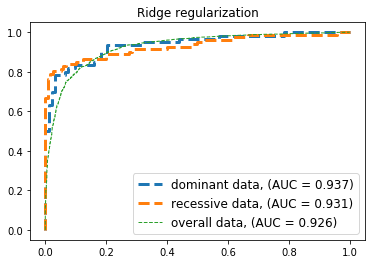

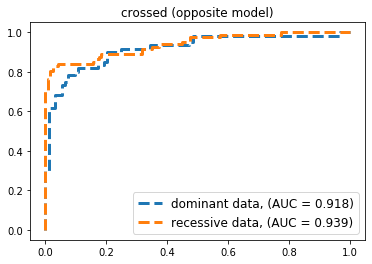

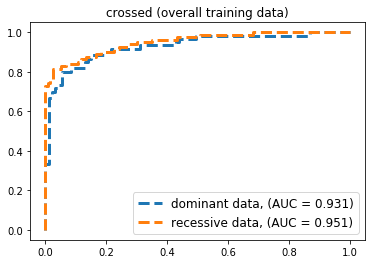

In [48]:
#logistic regression
def logistic(Xtrain, ytrain, Xtest, ytest, fitmodel = False):    
    if(fitmodel != False):
        model = fitmodel
        
    else:
        model = LogisticRegression(random_state = 42 , penalty = 'l2').fit(Xtrain, ytrain)
        
    test_hat = model.predict_proba(Xtest)[:,1]
    return(ytest,test_hat, model)


domi_l2 = logistic(X_train_domi, y_train_domi, X_test_domi, y_test_domi)
recess_l2 = logistic(X_train_recess, y_train_recess, X_test_recess, y_test_recess)
omit_l2 = logistic(X_train, y_train, X_test, y_test)
plt.rcParams['figure.figsize'] = [6,4]
drawROC(domi_l2[0], domi_l2[1],label = 'dominant data')
drawROC(recess_l2[0],recess_l2[1], label = "recessive data")
drawROC(omit_l2[0],omit_l2[1], lw =1,label = "overall data",lastone = True, title = "Ridge regularization")

# ridge cross
domi_l2_cross = logistic(0, 0, X_test_domi, y_test_domi, fitmodel = recess_l2[2])
recess_l2_cross = logistic(0,0, X_test_recess, y_test_recess, fitmodel = domi_l2[2])

drawROC(domi_l2_cross[0], domi_l2_cross[1],label = 'dominant data')
drawROC(recess_l2_cross[0],recess_l2_cross[1], label = "recessive data", lastone = True, title = "crossed (opposite model)")

# overall crossed
domi_l2_overall = logistic(0,0,X_test_domi, y_test_domi, fitmodel = omit_l2[2])
recess_l2_overall = logistic(0,0,X_test_recess, y_test_recess, fitmodel = omit_l2[2])

drawROC(domi_l2_overall[0], domi_l2_overall[1],label = 'dominant data')
drawROC(recess_l2_overall[0],recess_l2_overall[1], label = "recessive data", lastone = True, title = "crossed (overall training data)")

In [49]:
coef_domi = domi_l2[2].coef_.flatten()
coef_recess = recess_l2[2].coef_.flatten()
coef_overall = omit_l2[2].coef_.flatten()

cor_reg = pd.DataFrame({'domi_ridge':coef_domi, 'recess_ridge': coef_recess, 'overall': coef_overall}, index = x_column)
print(cor_reg)


                domi_ridge  recess_ridge   overall
SIFT_pred        -0.497038      0.170372  0.645350
LRT_pred          0.456137      0.310925  0.482625
MA_pred           0.071438      0.174238 -0.046896
PROVEN_pred       0.946255      0.163325  0.451827
SLR_score        -0.157330     -0.092086 -0.051674
SIFT_score       -0.161159     -0.183332  0.079870
LRT_omega        -0.049782      0.031658 -0.006684
MA_score          0.332386      0.347931  0.451213
PROVEN_score      0.217056     -0.627095 -0.306630
Grantham          0.283521     -0.017775 -0.014309
HMMEntropy        0.657568      0.132171 -0.284596
HMMRelEntropy    -0.412102     -0.024058  0.412234
PredRSAB          0.022864     -0.027301  0.006368
PredRSAI          0.156698      0.069800  0.004500
PredRSAE         -0.056210      0.055590 -0.008945
PredBFactorF      0.091609      0.323180  0.012639
PredBFactorM      0.039545      0.101735 -0.104006
PredBFactorS      0.063917      0.208925 -0.023391
PredStabilityH   -0.183987     

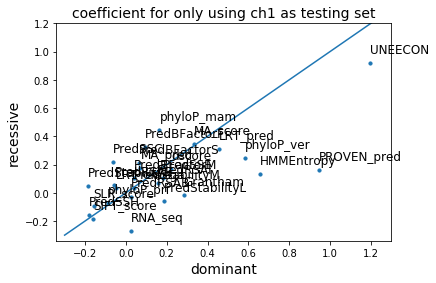

In [51]:
a = np.arange(-0.3,2)
plt.plot(a,a)
#plt.rcParams['figure.figsize'] = [20,10]
plt.scatter(cor_reg['domi_ridge'], cor_reg['recess_ridge'], s = 10)
i = 0
for x,y in zip(cor_reg['domi_ridge'], cor_reg['recess_ridge']):
    label = x_column[i]    
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext=(0,10,), # distance from text to points (x,y)
                 size = 12)
    i += 1
plt.xlim(-0.34,1.3)
plt.ylim(-0.34,1.2)
plt.title('coefficient for only using ch1 as testing set', size =14)
plt.xlabel('dominant', size = 14)
plt.ylabel('recessive', size = 14) 
plt.show()

In [52]:
# SVM
def svm_model(Xtrain, ytrain, Xtest, ytest, C, gamma, bestkernel, model = False):
    if(model != False):
        clf = model
        
    else: 
        print(C, gamma, bestkernel)
        clf = SVC(kernel = bestkernel, C = C, gamma = gamma)
        clf.fit(Xtrain, ytrain)

    test_hat = clf.decision_function(Xtest)
    return(ytest, test_hat, clf)


In [13]:
svm_domi = svm_model( X_train2_domi, y_train2_domi, X_test_domi, y_test_domi,10,1, 'rbf')
svm_recess = svm_model(X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 10,0.1, 'rbf')


10 1 rbf
10 0.1 rbf


In [16]:
svm_omit = svm_model(X_train2, y_train2, X_test, y_test, 10,1, 'rbf')

10 1 rbf


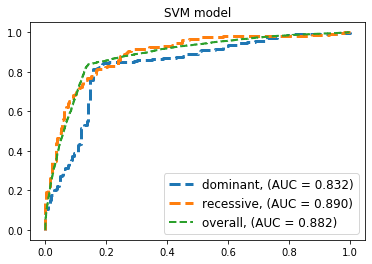

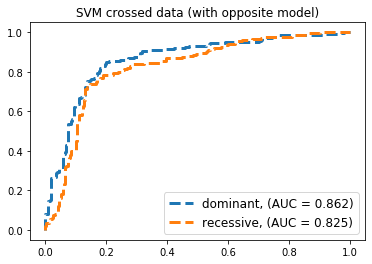

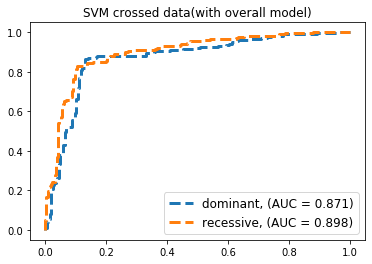

In [20]:
plt.rcParams['figure.figsize'] = [6,4]
drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
drawROC(svm_recess[0],svm_recess[1], label = 'recessive')
drawROC(svm_omit[0],svm_omit[1], lw = 2,label = 'overall', lastone = True, title = 'SVM model')

#cross model(dominant & recessive)
domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])

drawROC(domi_cross[0], domi_cross[1], label = 'dominant')
drawROC(recess_cross[0], recess_cross[1], label = 'recessive', lastone = True, title = 'SVM crossed data (with opposite model)')

#cross model(with overall data)
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

drawROC(domi_overall[0], domi_overall[1], label = 'dominant')
drawROC(recess_overall[0], recess_overall[1], label = 'recessive', lastone = True, title = 'SVM crossed data(with overall model)')

In [8]:
# SVM comparison with linear model

svm_domi = svm_model( X_train2_domi, y_train2_domi, X_test_domi, y_test_domi,100,1, 'linear')
svm_recess = svm_model(X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 10,0.01, 'linear')





100 1 linear
10 0.01 linear


In [9]:
svm_omit = svm_model(X_train2, y_train2, X_test, y_test, 100,1, 'linear')

100 1 linear


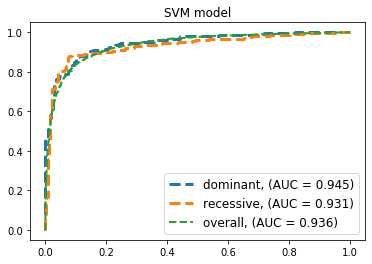

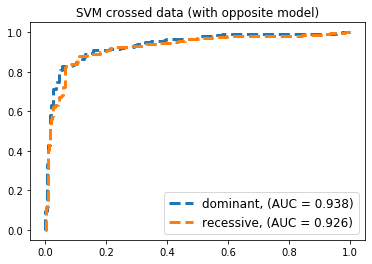

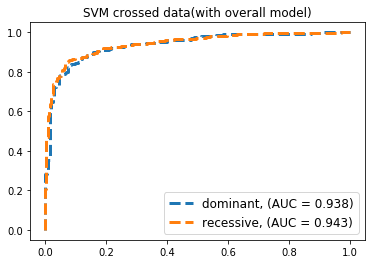

In [14]:
drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
drawROC(svm_recess[0],svm_recess[1], label = 'recessive')
drawROC(svm_omit[0],svm_omit[1], lw = 2,label = 'overall', lastone = True, title = 'SVM model')

#cross model(dominant & recessive)
domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])

drawROC(domi_cross[0], domi_cross[1], label = 'dominant')
drawROC(recess_cross[0], recess_cross[1], label = 'recessive', lastone = True, title = 'SVM crossed data (with opposite model)')

#cross model(with overall data)
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

drawROC(domi_overall[0], domi_overall[1], label = 'dominant')
drawROC(recess_overall[0], recess_overall[1], label = 'recessive', lastone = True, title = 'SVM crossed data(with overall model)')

In [21]:
# gradient boosting
tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}

In [22]:
#dominant
tuning(X_valid_domi, y_valid_domi, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
With score : 0.856

Grid scores on development set:

0.856 (+/-0.043) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.851 (+/-0.062) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.839 (+/-0.062) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.794 (+/-0.037) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.791 (+/-0.053) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.794 (+/-0.055) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.829 (+/-0.083) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.820 (+/-0.085) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.823 (+/-0.082) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.850 (+/-0.049) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.849 (+/-0.065) for 

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
#recessive
tuning(X_valid_recess, y_valid_recess, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
With score : 0.811

Grid scores on development set:

0.800 (+/-0.075) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.800 (+/-0.075) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.811 (+/-0.088) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.794 (+/-0.059) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.797 (+/-0.057) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.794 (+/-0.065) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.742 (+/-0.074) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.742 (+/-0.074) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.742 (+/-0.074) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.805 (+/-0.070) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.803 (+/-0.076) for 

In [61]:
#overall
tuning(X_valid, y_valid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
With score : 0.861

Grid scores on development set:

0.859 (+/-0.014) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.861 (+/-0.015) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.860 (+/-0.014) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.857 (+/-0.021) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.856 (+/-0.023) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.857 (+/-0.021) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.854 (+/-0.020) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.853 (+/-0.019) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.852 (+/-0.020) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.858 (+/-0.017) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.859 (+/-0.021) for 

In [23]:
def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, fitmodel = False):
    if(fitmodel == False):
        model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
        model.fit(Xtrain, ytrain)
    else:
        model = fitmodel
    
    model_pred = model.decision_function(Xtest)
    return(ytest, model_pred, model)

In [24]:
domi_gb = fitting_gb(X_train2_domi, y_train2_domi, X_test_domi, y_test_domi, 0.05, 3, 100)
recess_gb = fitting_gb( X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 0.05, 3, 200)
omit_gb = fitting_gb(X_train2, y_train2, X_test, y_test, 0.05, 3, 150)

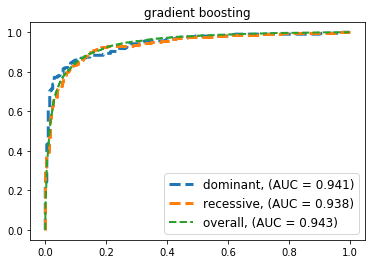

In [64]:
plt.rcParams['figure.figsize'] = [6,4]
drawROC(domi_gb[0], domi_gb[1], label = 'dominant')
drawROC(recess_gb[0], recess_gb[1], label = 'recessive')
drawROC(omit_gb[0], omit_gb[1], label = 'overall', lw = 2, lastone = True, title = 'gradient boosting')

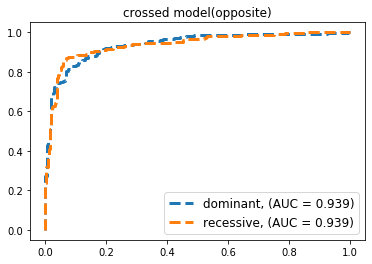

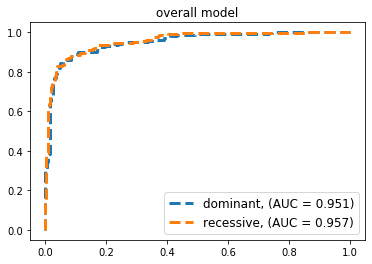

In [25]:
# cross model
domi_cross_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = recess_gb[2])
recess_cross_gb = fitting_gb(0,0, X_test_recess, y_test_recess ,0,0,0, fitmodel = domi_gb[2])

drawROC(domi_cross_gb[0], domi_cross_gb[1], label = 'dominant')
drawROC(recess_cross_gb[0], recess_cross_gb[1], label = 'recessive', lastone = True, title = 'crossed model(opposite)')


# using overall model
domi_overall_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = omit_gb[2])
recess_overall_gb = fitting_gb(0,0,X_test_recess, y_test_recess,0,0,0, fitmodel = omit_gb[2])

drawROC(domi_overall_gb[0], domi_overall_gb[1], label = 'dominant')
drawROC(recess_overall_gb[0], recess_overall_gb[1], label = 'recessive', lastone = True, title = 'overall model')



In [28]:
comparison = pd.DataFrame({'result':y_test, 'logistic':omit_l2[1] ,'svm': svm_omit[1],'boosting': omit_gb[1]})

comparison.to_csv('~/work/project/not_conflict/r_noconflict/validation_testing/validation_testing_comparison.tsv', sep = '\t',index = False)

In [29]:
domi_comparison = pd.DataFrame({'result':y_test_domi, 'boosting': domi_gb[1], 'opposite_model':domi_cross_gb[1], 'omit_model':domi_overall_gb[1]})

recess_comparison = pd.DataFrame({'result':y_test_recess, 'boosting': recess_gb[1], 'opposite_model':recess_cross_gb[1], 'omit_model':recess_overall_gb[1]})



domi_comparison.to_csv('~/work/project/not_conflict/r_noconflict/validation_testing/validation_testing_domi_comparison.tsv', sep = '\t',index = False)
recess_comparison.to_csv('~/work/project/not_conflict/r_noconflict/validation_testing/validation_testing_recess_comparison.tsv', sep = '\t',index = False)

In [28]:
domi_comparison

result  boosting  oppositemodel      omit
0         0 -2.808569      -4.281440 -0.529466
1         1  3.716112       4.512616  3.883463
2         1  3.683988       2.356506  3.660519
3         1  3.778864       4.523226  3.806221
4         1  3.752133       0.207186  1.648051
..      ...       ...            ...       ...
406       0 -5.587603      -5.924538 -3.780336
407       0 -2.196324      -2.230893 -1.865516
408       0 -4.552681      -5.447778 -3.525266
409       0 -5.250099      -4.875371 -3.933356
410       0 -5.465504      -6.021931 -3.725461

[411 rows x 4 columns]

In [1]:
print('2')

2


In [ ]:
domi_overall_gb[0], domi_overall_gb[1]